# Feature Engineering & Preprocessing Regression

In [1]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Functions

###  Extract Year and Month from 'src_month' Column

In [2]:
def process_src_month(df):
    df = df.copy()
    if 'src_month' in df.columns:
        df['src_month'] = pd.to_datetime(df['src_month'], errors='coerce')
        df['src_month_year'] = df['src_month'].dt.year
        df['src_month_month'] = df['src_month'].dt.month
        df.drop(columns=['src_month'], inplace=True)
    return df

### Preprocess Raw Apartment Data

In [3]:
def preprocess_data(df, loc_freq_map=None, is_train=True):
    df = df.copy()
    
    binary_cols = ['has_park', 'has_balcony', 'has_lift', 'has_sec', 'has_store']
    for col in binary_cols:
        df[col] = df[col].map({'yes': 1, 'no': 0})

    if 'has_lift' in df.columns:
        df['has_lift'] = df['has_lift'].fillna(df['has_lift'].mode()[0])


    df[['obj_type', 'own_type', 'build_mat']] = df[['obj_type', 'own_type', 'build_mat']].fillna("missing")

    median_cols = ['floor_no', 'floor_max', 'year_built', 'infrastructure_quality', 'dist_uni']
    df[median_cols] = df[median_cols].fillna(df[median_cols].median())

    dist_cols = ['dist_clinic', 'dist_rest', 'dist_pharma', 'dist_post', 'dist_kind', 'dist_sch']
    df[dist_cols] = df[dist_cols].fillna(df[dist_cols].median())

    if is_train:
        loc_freq_map = df['loc_code'].value_counts(normalize=True)
    df['loc_code_freq'] = df['loc_code'].map(loc_freq_map).fillna(0)

    df = df.drop(columns=['loc_code'], errors='ignore')
    df = df.drop(columns=['cond_class'], errors='ignore')  

    return (df, loc_freq_map) if is_train else df

### Generate Additional Features

In [4]:
def create_features(df):
    df = df.copy()
    df['age'] = 2025 - df['year_built']
    df['floor_ratio'] = df['floor_no'] / (df['floor_max'] + 1e-5)
    df['rooms_per_m2'] = df['n_rooms'] / (df['dim_m2'] + 1e-5)
    if 'price_z' in df.columns:
        df['price_per_m2'] = df['price_z'] / (df['dim_m2'] + 1e-5)
    return df

### Treat Outliers via Winsorization

In [5]:
def treat_outliers(df, columns):
    df = df.copy()
    for col in columns:
        if col in df.columns:
            df[col] = winsorize(df[col], limits=[0.01, 0.01])
    return df

### Apply Log Transformation to Reduce Skewness

In [6]:
def apply_log_transform(df, columns):
    df = df.copy()
    for col in columns:
        if col in df.columns:
            df[col + "_log"] = np.log1p(df[col])
    return df

### Select Relevant Features via Mutual Information (MI)

In [7]:
def feature_selection(df, target_col='price_z', mi_thresh=0.005):
    df = df.drop(columns=['unit_id'], errors='ignore')  
    X = df.drop(columns=[target_col])
    y = df[target_col]

    print("\n Starting Feature Selection using Mutual Information...")
    mi = mutual_info_regression(X, y, random_state=42)
    mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
    selected_features = mi_series[mi_series > mi_thresh].index.tolist()

    dropped = mi_series[mi_series <= mi_thresh]
    print(f" Dropped by MI ({len(dropped)} features):")
    for feat, val in dropped.items():
        print(f" - {feat}: MI={val:.4f}")

    return df[selected_features + [target_col]], selected_features

### Drop Highly Correlated Features and Redundant Raw Columns

In [8]:
def drop_high_corr_and_raw_versions(train_df, test_df, log_suffix="_log", corr_thresh=0.90):
    train_df = train_df.copy()
    test_df = test_df.copy()

    # Keep only log transformed versions
    log_cols = [col for col in train_df.columns if col.endswith(log_suffix)]
    raw_cols_to_drop = []
    for log_col in log_cols:
        raw_col = log_col.replace(log_suffix, "")
        if raw_col in train_df.columns:
            raw_cols_to_drop.append(raw_col)
    print(f"Dropping original (non-log) versions of log-transformed features: {raw_cols_to_drop}")
    train_df.drop(columns=raw_cols_to_drop, inplace=True, errors='ignore')
    test_df.drop(columns=raw_cols_to_drop, inplace=True, errors='ignore')

    # Addressing highly correlated features
    corr_matrix = train_df.drop(columns=['price_z'], errors='ignore').corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop_corr = []
    for column in upper.columns:
        highly_corr = upper[column][upper[column] > corr_thresh].index.tolist()
        for correlated_feature in highly_corr:
            # If neither feature is dropped, choose the log one.
            if correlated_feature not in to_drop_corr and column not in to_drop_corr:
                prefer_keep = column if column.endswith(log_suffix) else correlated_feature
                prefer_drop = correlated_feature if prefer_keep == column else column
                to_drop_corr.append(prefer_drop)
    print(f"Dropping highly correlated features (|r| > {corr_thresh}): {to_drop_corr}")
    train_df.drop(columns=to_drop_corr, inplace=True, errors='ignore')
    test_df.drop(columns=to_drop_corr, inplace=True, errors='ignore')

    return train_df, test_df

# Full Data Preprocessing Pipeline

In [9]:
train = pd.read_csv(r"C:\Users\YILMAZ\Desktop\appartments_train.csv")
test = pd.read_csv(r"C:\Users\YILMAZ\Desktop\appartments_test.csv")

In [10]:
train = process_src_month(train)
test = process_src_month(test)

In [11]:
train_fe, loc_freq_map = preprocess_data(train, is_train=True)
test_fe = preprocess_data(test, loc_freq_map=loc_freq_map, is_train=False)

In [12]:
train_fe = create_features(train_fe)
test_fe = create_features(test_fe)

In [13]:
outlier_cols = ['dim_m2', 'n_rooms', 'n_poi', 'estimated_maintenance_cost', 'dist_centre']
train_fe = treat_outliers(train_fe, outlier_cols)
test_fe = treat_outliers(test_fe, outlier_cols)

In [14]:
log_cols = [
    'dim_m2', 'floor_no', 'floor_max', 'dist_centre', 'n_poi', 'dist_sch', 'dist_clinic',
    'dist_post', 'dist_kind', 'dist_rest', 'dist_uni', 'dist_pharma',
    'market_volatility', 'infrastructure_quality', 'estimated_maintenance_cost'
]
train_fe = apply_log_transform(train_fe, log_cols)
test_fe = apply_log_transform(test_fe, log_cols)

In [15]:
low_card_cols = ['obj_type', 'own_type', 'build_mat']
train_fe = pd.get_dummies(train_fe, columns=low_card_cols, drop_first=True)
test_fe = pd.get_dummies(test_fe, columns=low_card_cols, drop_first=True)

In [16]:
bool_cols = train_fe.select_dtypes(include='bool').columns.tolist()
train_fe[bool_cols] = train_fe[bool_cols].astype(int)
test_fe[bool_cols] = test_fe[bool_cols].astype(int)

In [17]:
common_cols = list(set(train_fe.columns) & set(test_fe.columns))
if 'price_z' in train_fe.columns:
    common_cols.append('price_z')

train_fe = train_fe[common_cols]
test_fe = test_fe[[col for col in common_cols if col != 'price_z']]

print(f" Final train shape: {train_fe.shape}")
print(f" Final test shape: {test_fe.shape}")

 Final train shape: (156454, 56)
 Final test shape: (39114, 55)


# Examining The Relationship Between The Last Features And Feature Selection

In [18]:
print(train_fe.dtypes)

neighborhood_crime_rate           float64
has_sec                             int64
dist_clinic                       float64
own_type_4e625087                   int32
floor_max_log                     float64
year_built                        float64
dist_post                         float64
green_space_ratio                 float64
dist_kind                         float64
estimated_maintenance_cost        float64
rooms_per_m2                      float64
unit_id                            object
has_park                            int64
age                               float64
dim_m2_log                        float64
floor_max                         float64
has_balcony                         int64
market_volatility                 float64
n_poi                             float64
dist_clinic_log                   float64
src_month_month                     int32
dist_rest                         float64
src_month_year                      int32
own_type_bfb8fe10                 

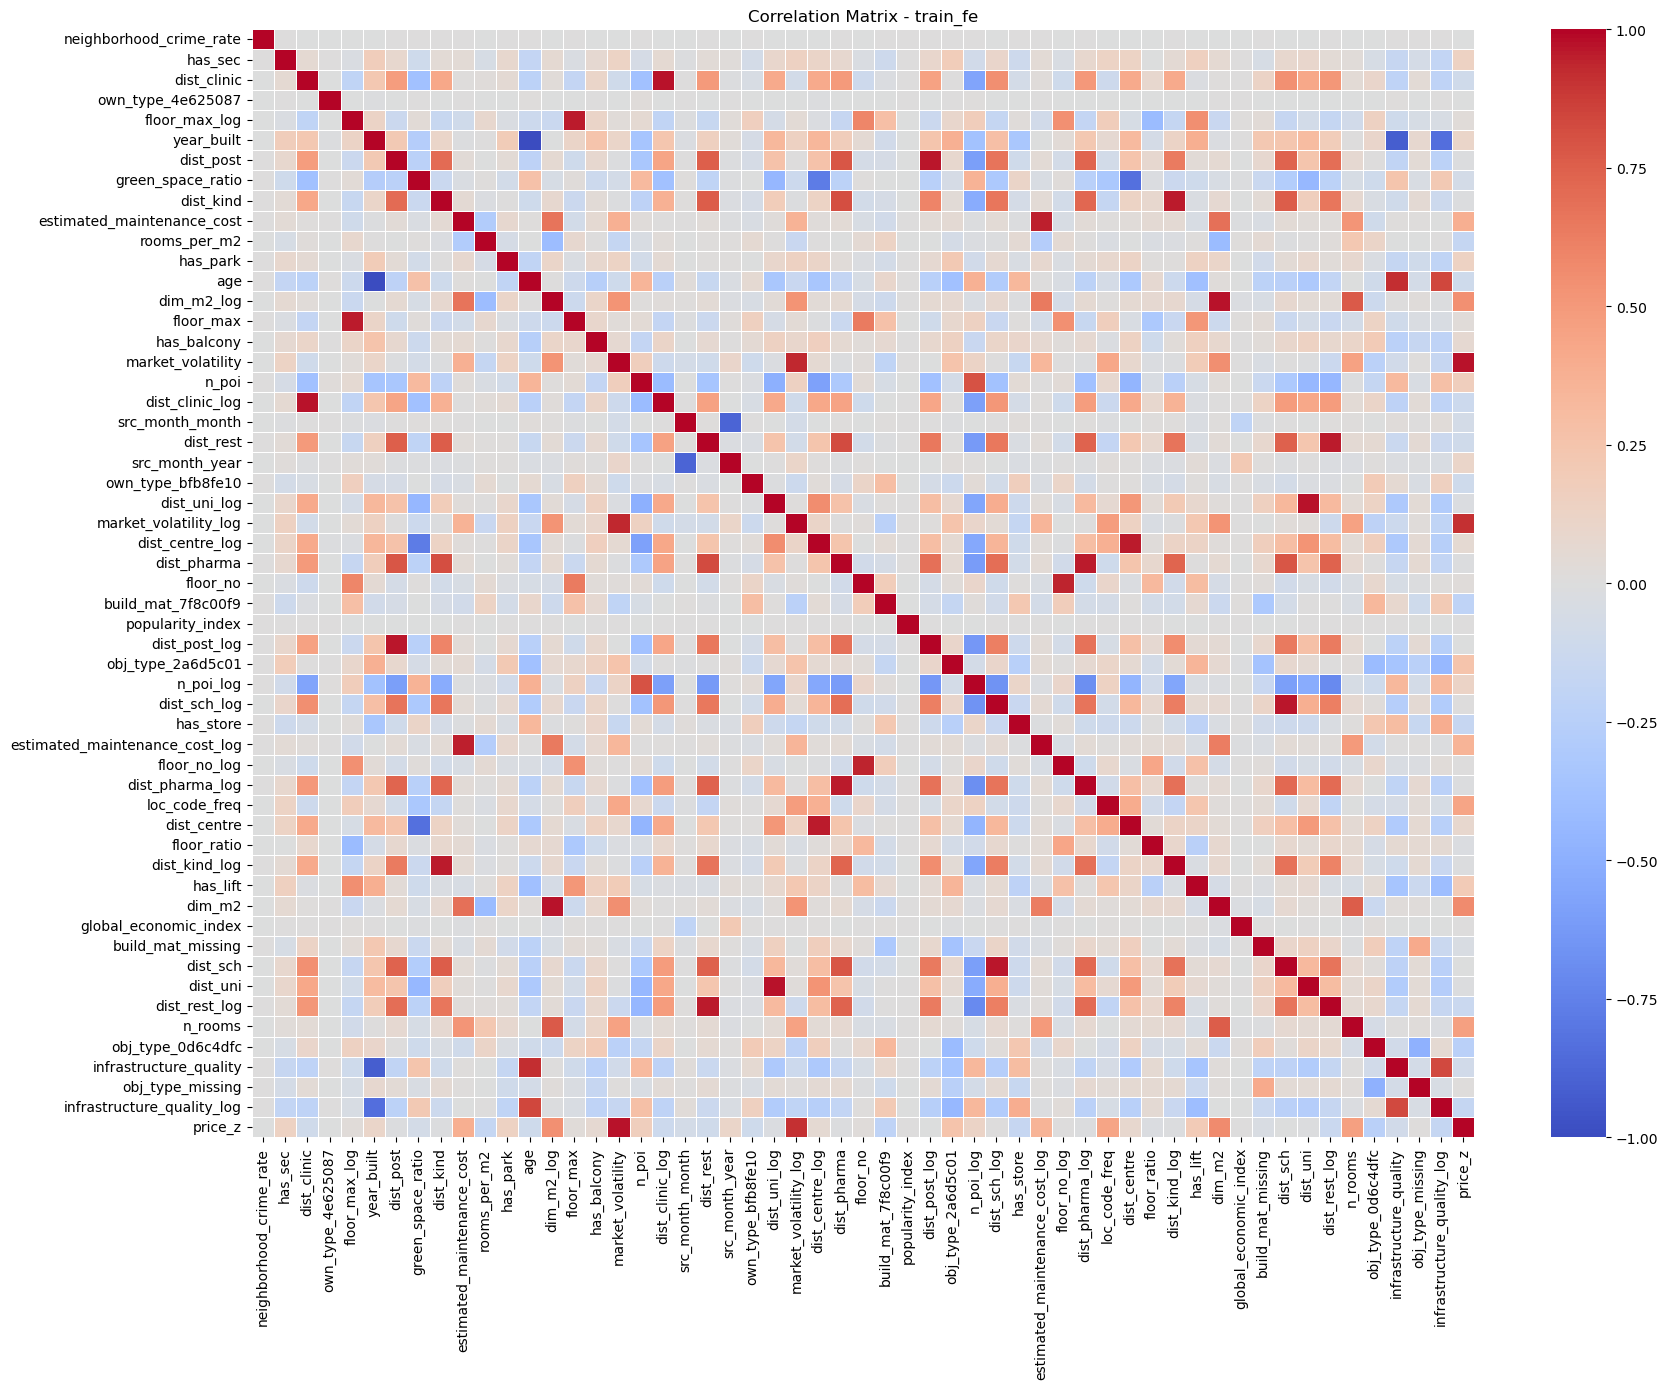

In [19]:
numeric_df = train_fe.drop(columns=['unit_id'], errors='ignore')

corr_matrix = numeric_df.corr()

plt.figure(figsize=(18, 14))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Correlation Matrix - train_fe")
plt.tight_layout()
plt.show()

In [20]:
print(corr_matrix)

                                neighborhood_crime_rate   has_sec  \
neighborhood_crime_rate                        1.000000  0.002250   
has_sec                                        0.002250  1.000000   
dist_clinic                                   -0.000190  0.061109   
own_type_4e625087                             -0.004591  0.002639   
floor_max_log                                 -0.000282 -0.028001   
year_built                                    -0.001407  0.174592   
dist_post                                      0.002508  0.078486   
green_space_ratio                              0.001149 -0.102973   
dist_kind                                      0.000628  0.045324   
estimated_maintenance_cost                     0.000708  0.040964   
rooms_per_m2                                  -0.001125 -0.053048   
has_park                                       0.001310  0.081432   
age                                            0.001407 -0.174592   
dim_m2_log                        

In [21]:
threshold = 0.90

high_corrs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        var1 = corr_matrix.columns[i]
        var2 = corr_matrix.columns[j]
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) >= threshold:
            high_corrs.append((var1, var2, corr_value))

print("Pairs of variables with a correlation greater than or equal to 90%:\n")
for var1, var2, value in high_corrs:
    print(f"{var1} ↔ {var2} : correlation = {value:.4f}")

Pairs of variables with a correlation greater than or equal to 90%:

dist_clinic ↔ dist_clinic_log : correlation = 0.9738
floor_max_log ↔ floor_max : correlation = 0.9542
year_built ↔ age : correlation = -1.0000
year_built ↔ infrastructure_quality : correlation = -0.9189
dist_post ↔ dist_post_log : correlation = 0.9621
dist_kind ↔ dist_kind_log : correlation = 0.9603
estimated_maintenance_cost ↔ estimated_maintenance_cost_log : correlation = 0.9518
age ↔ infrastructure_quality : correlation = 0.9189
dim_m2_log ↔ dim_m2 : correlation = 0.9729
market_volatility ↔ market_volatility_log : correlation = 0.9312
market_volatility ↔ price_z : correlation = 0.9725
dist_rest ↔ dist_rest_log : correlation = 0.9556
dist_uni_log ↔ dist_uni : correlation = 0.9740
market_volatility_log ↔ price_z : correlation = 0.9106
dist_centre_log ↔ dist_centre : correlation = 0.9548
dist_pharma ↔ dist_pharma_log : correlation = 0.9592
floor_no ↔ floor_no_log : correlation = 0.9392
dist_sch_log ↔ dist_sch : correl

In [22]:
train_fe_selected, selected_features = feature_selection(train_fe) 


 Starting Feature Selection using Mutual Information...
 Dropped by MI (9 features):
 - dist_post: MI=0.0039
 - dist_post_log: MI=0.0033
 - dist_kind_log: MI=0.0009
 - popularity_index: MI=0.0007
 - dist_kind: MI=0.0006
 - own_type_4e625087: MI=0.0000
 - global_economic_index: MI=0.0000
 - obj_type_missing: MI=0.0000
 - neighborhood_crime_rate: MI=0.0000


In [23]:
train_fe_cleaned, test_fe_cleaned = drop_high_corr_and_raw_versions(train_fe_selected, test_fe[selected_features])

Dropping original (non-log) versions of log-transformed features: ['market_volatility', 'dim_m2', 'infrastructure_quality', 'estimated_maintenance_cost', 'floor_max', 'dist_centre', 'n_poi', 'dist_rest', 'dist_clinic', 'dist_sch', 'dist_uni', 'floor_no', 'dist_pharma']
Dropping highly correlated features (|r| > 0.9): ['year_built']


# Scaling

In [25]:
train_scaled = train_fe_cleaned.copy()
test_scaled = test_fe_cleaned.copy()

num_cols = train_scaled.select_dtypes(include='number').columns.drop('price_z')

scaler = StandardScaler()
train_scaled[num_cols] = scaler.fit_transform(train_scaled[num_cols])
test_scaled[num_cols] = scaler.transform(test_scaled[num_cols])

# Saving Data

In [26]:
desktop_path = r"C:\Users\YILMAZ\Desktop\\"

# NON-SCALED
train_fe_cleaned.to_csv(os.path.join(desktop_path, "train_fe.csv"), index=False)
test_fe_cleaned.to_csv(os.path.join(desktop_path, "test_fe.csv"), index=False)

# SCALED
train_scaled.to_csv(os.path.join(desktop_path, "train_fe_scaled.csv"), index=False)
test_scaled.to_csv(os.path.join(desktop_path, "test_fe_scaled.csv"), index=False)